# Simplifying things

The method used in chapter 2 has been written up in two python scripts, simplyifying the analysis process for a galaxy.

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import groupPolylines
import pcaSpiralExtract
import spiralExtraction
import json

In [4]:
with open('classification-dump.json') as f: classifications = json.load(f)
with open('subject-dump.json') as f: subjects = json.load(f)
# print(json.dumps(list(cls[0]['links']['subjects']), indent=1))
index, _ = (next(iter(filter(
    lambda s: s[1] == '6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10',
    ((i, list(s['locations'][0].items())[0][1].split('/')[-1].split('.')[0]) for i, s in enumerate(subjects))
))))

subjectId = subjects[index]['id']

classificationsOfSubject = list(filter(lambda c: c['links']['subjects'][0] == subjectId, classifications))
annotations = [c['annotations'] for c in classificationsOfSubject]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [[[p['x'], p['y']] for p in a] for a in c]
    for c in spirals if all([len(a) > 5 for a in c])
]
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])

And then perform the algorithm!

In [29]:
functions = spiralExtraction.fit(drawnArms)

Calculating distance matrix (this can be slow)
Clustering arms
Working on arm label 0
	[1 / 4] Cleaning points (3743 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
Working on arm label 1
	[1 / 4] Cleaning points (2665 total)
	[2 / 4] Identifiying most representitive arm
	[3 / 4] Sorting points
	[4 / 4] Fitting Spline
done!


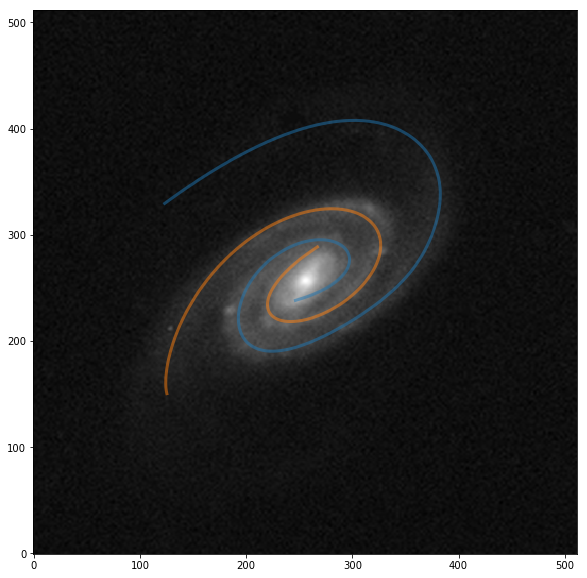

In [30]:
from PIL import Image
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))

pic = Image.open("./images/beta_subject.png")
ax.imshow(np.transpose(np.array(pic)[::-1, ::1]), cmap='gray', origin='lower')

t = np.linspace(0, 1, 1000)
for Sx, Sy in functions:
    ax.plot((Sx(t) + 0.5) * 512, (Sy(t) + 0.5) * 512, linewidth=3, alpha=0.5)

In [5]:
db = groupPolylines.clusterPolyLines(drawnArms)
armLabels = db.labels_

1 of 2: Calculating distance matrix...
2 of 2: Running DBSCAN
Estimated number of clusters: 2


/Users/tlingard/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in true_divide


(23, 2) (19, 2)
[[290.  275. ]
 [271.5 248.6]
 [314.4 400.4]
 [374.3 377.5]
 [183.8 364.5]
 [273.  256. ]
 [372.6 344.8]
 [369.3 383. ]
 [193.8 237.5]
 [262.  430.5]
 [378.3 355.8]
 [362.2 371. ]
 [371.  308.5]
 [277.5 253.9]
 [370.  373.5]
 [295.  404.5]
 [377.5 372.4]
 [379.  375.5]
 [376.5 375.5]
 [379.7 334.1]
 [206.4 253.4]
 [328.3 401.5]
 [278.7 261.6]
 [136.2 345.6]
 [293.6 268.7]
 [272.3 249.5]
 [380.  310.3]
 [370.8 363.5]
 [264.  244.4]
 [268.3 242.8]
 [260.9 248.9]
 [289.  266.5]
 [260.5 407.9]
 [168.  336. ]
 [260.  242.5]
 [260.  239.5]
 [384.8 345.5]
 [223.6 185.6]
 [187.  214.5]
 [288.5 261.5]
 [288.  293.8]
 [380.  367.4]]
Dropping 15 sticks
(22, 2) (14, 2)
[[237.5 263.5]
 [238.9 268.7]
 [249.8 211.5]
 [249.3 277.5]
 [115.1 177.9]
 [146.5 217.9]
 [137.9 149.8]
 [222.8 250.5]
 [249.  273.5]
 [123.3 183.8]
 [136.5 157.5]
 [120.9 164. ]
 [221.  238.5]
 [142.  172.5]
 [131.8 168.5]
 [224.6 216.8]
 [142.  148.5]
 [230.  254.5]
 [230.5 265.5]
 [226.3 222.8]
 [248.  270.5]
 [2

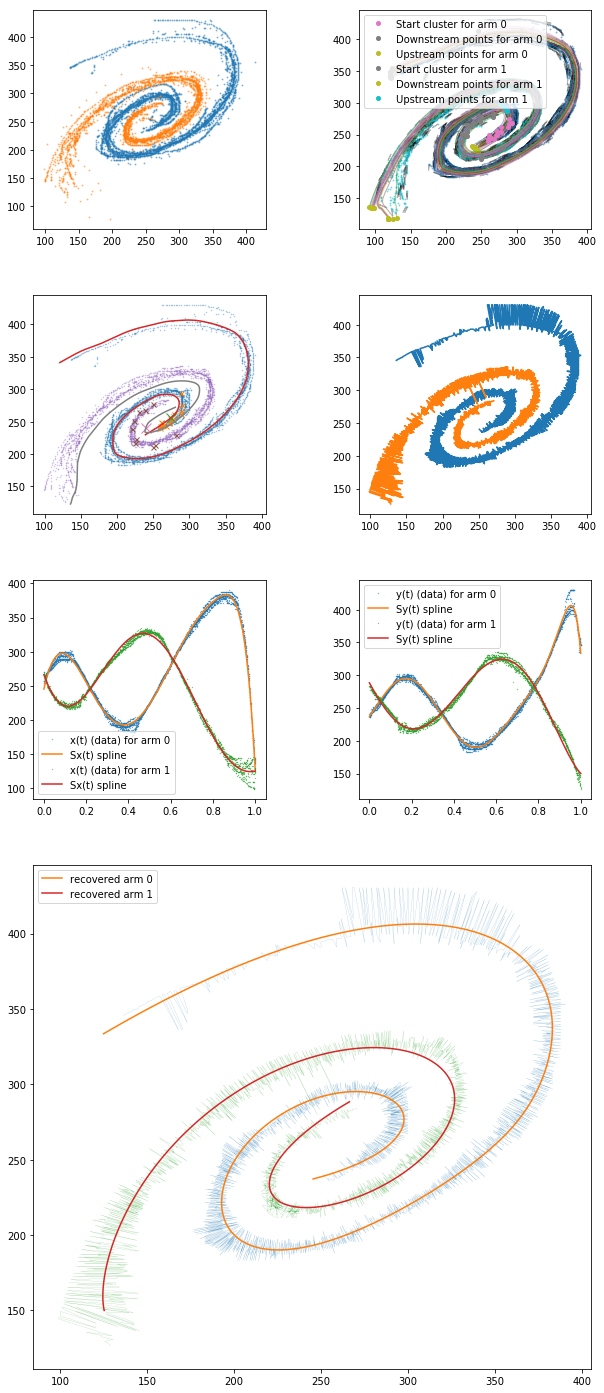

In [6]:
plt.figure(figsize=(10, 25))
grid = plt.GridSpec(5, 2, wspace=0.4, hspace=0.3)
ax0 = plt.subplot(grid[0, 0])
ax1 = plt.subplot(grid[0, 1])
ax2 = plt.subplot(grid[1, 0])
ax3 = plt.subplot(grid[1, 1])
ax4 = plt.subplot(grid[2, 0])
ax5 = plt.subplot(grid[2, 1])
ax6 = plt.subplot(grid[3:, :])
    
splines = []
for armLabel in range(np.max(armLabels) + 1):
    pointCloud = np.concatenate(drawnArms[armLabels == armLabel])
    ax0.plot(pointCloud[:, 0], pointCloud[:, 1], '.', markersize=2, alpha=0.4)
    cleanedCloud, outlierMask = groupPolylines.identifyOutliers(pointCloud)
    vectorField, variances = pcaSpiralExtract.getVectorField(cleanedCloud)
    varianceCutoffMask = variances[:, 0] / variances[:, 1] > 3.0
    cleanedVectorField = vectorField[varianceCutoffMask]
    
    startCluster = pcaSpiralExtract.getStartCluster(drawnArms[armLabels == armLabel], cleanedCloud)
    paths = pcaSpiralExtract.dropSticks(startCluster, cleanedVectorField)
    downstreamPoints = np.array([p[-1] for p in paths])
    upstreamPoints = np.array([p[0] for p in paths])
    
    downstreamClusterMask = pcaSpiralExtract.findDownstreamCluster(downstreamPoints)

    startPoint = (
        np.add.reduce(startCluster[downstreamClusterMask]) /
        startCluster[downstreamClusterMask].shape[0]
    )
    finalPath = pcaSpiralExtract.dropStick(startPoint, cleanedVectorField)
    
    res = pcaSpiralExtract.sortCloudAlongLine(cleanedCloud, finalPath)
    pointOrder = np.argsort(res[0])
    
    Sx, Sy = pcaSpiralExtract.fitParametrisedSpline(cleanedCloud[pointOrder]/512)
    splines.append([Sx, Sy])
    for point in cleanedVectorField:
        ax1.arrow(point[0], point[1], point[2]*10, point[3]*10, color='k', alpha=0.3)
    ax1.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=2, alpha=0.4)
    for path in paths:
        ax1.plot(path[:, 0], path[:, 1], linewidth=1, alpha=0.5)
    ax1.plot(startCluster[:, 0], startCluster[:, 1], '.', markersize=8, alpha=1, label="Start cluster for arm {}".format(armLabel))
    ax1.plot(downstreamPoints[:, 0], downstreamPoints[:, 1], '.', markersize=8, alpha=1,  label="Downstream points for arm {}".format(armLabel))
    ax1.plot(upstreamPoints[:, 0], upstreamPoints[:, 1], '.', markersize=8, alpha=1, label="Upstream points for arm {}".format(armLabel))
    
    ax2.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=1, alpha=0.4)
    ax2.plot(startCluster[downstreamClusterMask, 0], startCluster[downstreamClusterMask, 1], 'x', markersize=5, label="Drawn starting point of classifications for arm {}".format(armLabel))
    ax2.plot([startPoint[0]], [startPoint[1]], 'x', markersize=10, label="Chosen start point for arm {}".format(armLabel))
    ax2.plot(finalPath[:, 0], finalPath[:, 1])
    
    ax3.plot(cleanedCloud[pointOrder, 0], cleanedCloud[pointOrder, 1])

    t = np.linspace(0, 1, cleanedCloud.shape[0])
    ax4.plot(t, cleanedCloud[pointOrder, 0], '.', markersize=0.5, label='x(t) (data) for arm {}'.format(armLabel))
    ax4.plot(t, 512*Sx(t), label='Sx(t) spline')
    ax4.legend()

    ax5.plot(t, cleanedCloud[pointOrder,1], '.', markersize=0.5, label='y(t) (data) for arm {}'.format(armLabel))
    ax5.plot(t, 512*Sy(t), label='Sy(t) spline')
    ax5.legend()

    ax6.plot(cleanedCloud[pointOrder, 0], cleanedCloud[pointOrder, 1], linewidth=0.1)
    ax6.plot(512*Sx(t), 512*Sy(t), label='recovered arm {}'.format(armLabel))

ax1.legend()
ax4.legend()
ax5.legend()
ax6.legend()
plt.savefig('images/recoveredSpiral.png')

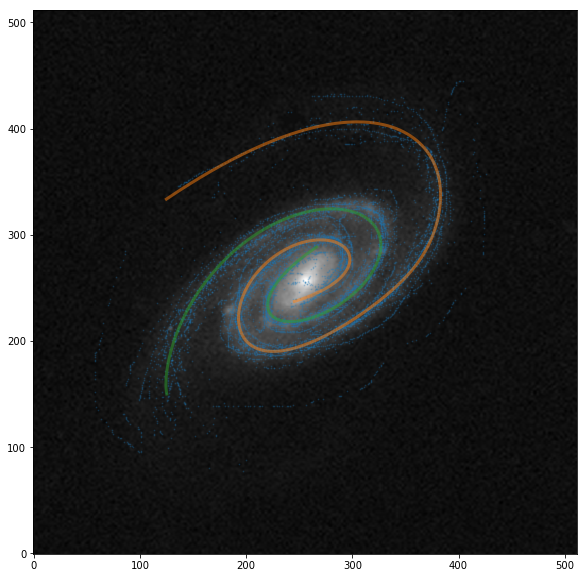

In [7]:
from PIL import Image
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))

pointCloud2 = np.array([
    point for arm in drawnArms
    for point in arm
])

pic = Image.open("./images/beta_subject.png")
ax.imshow(np.transpose(np.array(pic)[::-1, ::1]), cmap='gray', origin='lower')
ax.plot(pointCloud2[:, 0], pointCloud2[:, 1], '.', markersize=2, alpha=0.2, label='points identified as part of spiral 1 (not analysed here)')
for Sx, Sy in splines:
    t = np.linspace(0, 1, 5000)
    ax.plot(Sx(t)*512, Sy(t)*512, linewidth=3, alpha=0.5)
plt.savefig('images/overlaidSplines.png')

### Next steps

Well it looks like we have a spiral! We still need to finalise start/end points, but the next step is to test how resilient this method is when using fewer classifications (i.e. does our retirement limit make sense?)

This test galaxy from the beta received 47 classifications, in the next chapter we'll explore what happens if we drop that to 10.